# Notebook and Environment Setup 
This initial cell ensures that the Jupyter Notebook environment is correctly configured to run the rest of the project.

In [19]:
import os
import sys

# Get the directory of the currently running notebook, which should be the project root
# Using os.getcwd() is a reliable start in Jupyter/VS Code environments
notebook_dir = os.path.abspath(os.getcwd())

# Ensure we are at the highest level des646_project
if notebook_dir.endswith(os.path.join('des646_project', 'testing')):
# If the CWD is 'testing', we move UP one level to the project root
    project_root = os.path.dirname(notebook_dir)
elif not notebook_dir.endswith('des646_project'):
# A generic case if the notebook is run from a subfolder
    project_root = os.path.dirname(os.path.abspath('diagnostics_check.ipynb')) 
else:
# If we are already in the correct folder (des646_project)
    project_root = notebook_dir

# Set the Current Working Directory (CWD) to the project root
os.chdir(project_root)

# Add the project root to the Python path for local imports
if project_root not in sys.path:
    sys.path.append(project_root)

print("Current Working Directory:", os.getcwd())
print("Notebook path configured.")

Current Working Directory: c:\Users\Shrimi Agrawal\OneDrive\Desktop\DES646\des646_project
Notebook path configured.


# Diversity and Class Separation Analysis
This section analyzes the quality of the dataset based on pre-computed embeddings. The goal is to measure how distinct (separated) classes are from each other and how diverse (spread out) the samples are within each class.
**Key Metrics Computed:**
* **Intra-Class Diversity:** Measures the mean pairwise distance between samples within the same class. (Higher = more diverse class content).
* **Inter-Class Overlap:** Measures the Fréchet Distance between the distribution of features for each pair of classes. (Higher = better separation, lower = more overlap).
* **Diversity Index:** A combined metric used to summarize overall dataset quality (Intra / Inter).
**Visualization:** A heatmap is generated to visualize the Inter-Class Overlap matrix, showing potential confusing pairs of classes.

c:\Users\Shrimi Agrawal\OneDrive\Desktop\DES646\des646_project\diagnostics\diversity.py:66: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean = sqrtm(sigma1 @ sigma2)
c:\Users\Shrimi Agrawal\OneDrive\Desktop\DES646\des646_project\diagnostics\diversity.py:66: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean = sqrtm(sigma1 @ sigma2)


Intra-class stats:
        class  n_samples  mean_distance  variance_distance
0  AnkleBoot         20      13.952075          15.480836
1        Bag         20      17.744978          26.351191
2       Coat         20      16.171581          17.891626
3      Dress         20      15.516515          22.922598
4   Pullover         20      16.407310          19.670050
5     Sandal         20      14.546216          16.797617
6      Shirt         20      17.576153          24.658272
7    Sneaker         20      12.293544          11.924448
8    T-shirt         20      17.471573          24.262669
9    Trouser         20      11.560680          10.496064
Inter-class overlap:
             AnkleBoot         Bag        Coat       Dress    Pullover  \
AnkleBoot    0.000000  320.245620  346.785903  290.459560  346.923720   
Bag        320.245620    0.000000  340.852099  371.550240  317.655349   
Coat       346.785903  340.852099    0.000000  278.788088  200.235445   
Dress      290.459560  371.5

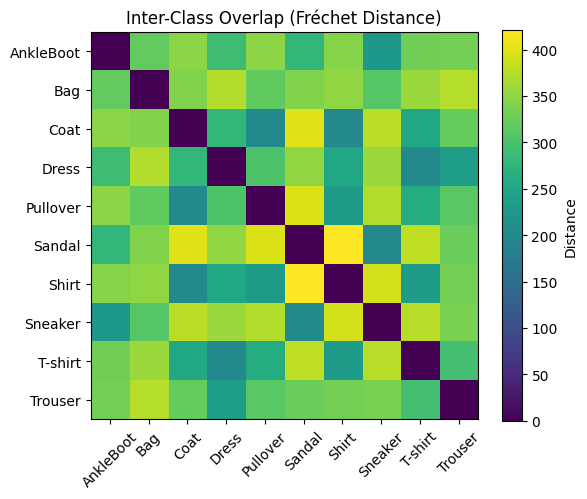

In [20]:
from diagnostics.diversity import (
    compute_intra_class_diversity,
    compute_inter_class_overlap,
    compute_diversity_index,
    plot_diversity_heatmap
)
import numpy as np
import pandas as pd
import os

base_dir = "testing/output"
embeddings = np.load(os.path.join(base_dir, "embeddings_resnet18.npy"))
labels = np.load(os.path.join(base_dir, "labels.npy"))

intra = compute_intra_class_diversity(embeddings, labels)
inter = compute_inter_class_overlap(embeddings, labels)
summary = compute_diversity_index(embeddings, labels)

print("Intra-class stats:\n", intra)
print("Inter-class overlap:\n", inter)
print("Diversity summary:", summary)

plot_diversity_heatmap(inter)

# Duplicate and Near-Duplicate Analysis

This section identifies potentially redundant or low-value samples in the dataset by checking for **near-perfect copies** using **cosine similarity** on the pre-computed embeddings.

**How it works:**
1.  Samples are compared in batches using cosine similarity.
2.  If the similarity exceeds a set **threshold (e.g., 0.90)**, they are grouped as duplicates using a Union-Find algorithm. 
3.  The output flags clusters of duplicate samples and identifies one **representative** for each cluster.

**Key Parameter:**
* **THRESHOLD:** Controls the strictness of the detection. A higher value (e.g., 0.98) finds only identical copies, while a lower value (e.g., 0.90) finds visually similar, near-duplicate images.

In [21]:
# DUPICATE ANALYSIS

# Import functions from your local module
from diagnostics.duplicates import (
    find_duplicates,
    summarize_duplicates
)
# Re-use or load necessary data
base_dir = "testing/output"
embeddings = np.load(os.path.join(base_dir, "embeddings_resnet18.npy"))
print(f"Embeddings loaded for duplicate analysis: {embeddings.shape}")


# Load image IDs for better summary
image_ids_path = os.path.join(base_dir, "image_ids.txt")
image_ids = None

if os.path.exists(image_ids_path):
    with open(image_ids_path, 'r') as f:
        image_ids = [line.strip() for line in f]
    print("Image IDs loaded for summary.")
else:
    print("Warning: image_ids.txt not found. Summary will use indices.")


# 4. Find duplicates
THRESHOLD = 0.90  # High threshold means very close matches
print(f"\n Finding duplicates with threshold: {THRESHOLD}")
duplicate_clusters = find_duplicates(embeddings, threshold=THRESHOLD)

# 5. Summarize results
duplicate_summary = summarize_duplicates(duplicate_clusters, image_ids=image_ids)


# 6. Print Results
print(f"\n otal Duplicate Clusters Found: {len(duplicate_summary)}")
print(f"Total Affected Samples: {sum(s['count'] for s in duplicate_summary)}")

print("\nTop 5 Clusters:")
for s in duplicate_summary[:5]:
    print(f"  Representative: {s['representative']}, Count: {s['count']}")
    print(f"  Duplicates: {s['duplicates']}")

Embeddings loaded for duplicate analysis: (200, 512)
Image IDs loaded for summary.

 Finding duplicates with threshold: 0.9

 otal Duplicate Clusters Found: 13
Total Affected Samples: 90

Top 5 Clusters:
  Representative: fashionmnist_sample/AnkleBoot/89.png, Count: 17
  Duplicates: ['fashionmnist_sample/AnkleBoot/167.png', 'fashionmnist_sample/AnkleBoot/15.png', 'fashionmnist_sample/AnkleBoot/107.png', 'fashionmnist_sample/AnkleBoot/122.png', 'fashionmnist_sample/AnkleBoot/42.png', 'fashionmnist_sample/AnkleBoot/208.png', 'fashionmnist_sample/AnkleBoot/93.png', 'fashionmnist_sample/AnkleBoot/44.png', 'fashionmnist_sample/AnkleBoot/79.png', 'fashionmnist_sample/AnkleBoot/90.png', 'fashionmnist_sample/Sneaker/162.png', 'fashionmnist_sample/Sneaker/108.png', 'fashionmnist_sample/Sneaker/119.png', 'fashionmnist_sample/Sneaker/6.png', 'fashionmnist_sample/Sneaker/46.png', 'fashionmnist_sample/Sneaker/52.png']
  Representative: fashionmnist_sample/Bag/200.png, Count: 2
  Duplicates: ['fashi

# Class Imbalance and Dataset Diversity Analysis

This section analyzes the **distribution of samples** across the dataset's classes, which is vital for diagnosing potential training issues (e.g., model bias towards majority classes).

**Key Metrics Computed:**

* **Class Distribution Table:** Shows the raw counts and proportion for every class, sorted from largest to smallest.
* **Shannon Entropy / Gini Index:** These are statistical measures of **diversity** and **inequality** in the class proportions. 
    * *Lower* Entropy/Gini indicates *higher* imbalance.
* **Effective Number of Classes (ENC):** Measures how many classes effectively contribute to the dataset's diversity (an ENC much lower than the actual number of classes suggests high imbalance).
* **Underrepresented Classes:** Flags classes whose proportion falls below a defined threshold (default 10%).
**Visualization:** A histogram provides a quick visual check of the count disparity between classes.

Labels shape: (200,)

 Computing Imbalance and Diversity Metrics...

Diversity Metrics Summary:
  - Shannon Entropy: 3.3219
  - Gini Index: 0.9
  - Effective Classes: 10.0

 Total Classes: 10
 Underrepresented Classes (< 10%): []

 Full Class Distribution Table:
| class     |   count |   proportion |
|:----------|--------:|-------------:|
| AnkleBoot |      20 |          0.1 |
| Bag       |      20 |          0.1 |
| Coat      |      20 |          0.1 |
| Dress     |      20 |          0.1 |
| Pullover  |      20 |          0.1 |
| Sandal    |      20 |          0.1 |
| Shirt     |      20 |          0.1 |
| Sneaker   |      20 |          0.1 |
| T-shirt   |      20 |          0.1 |
| Trouser   |      20 |          0.1 |


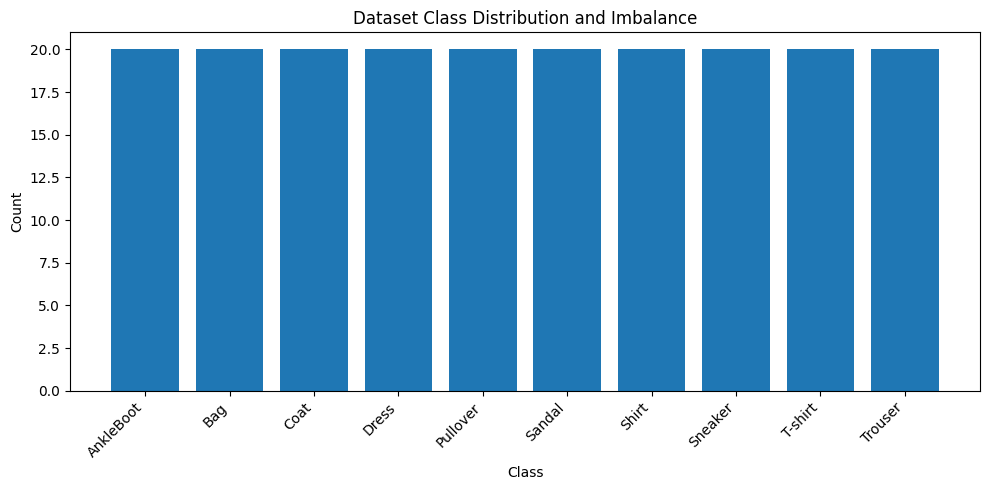

In [22]:
# CLASS IMBALANCE ANALYSIS
# Import functions from your local module
from diagnostics.imbalance import (
    summarize_imbalance,
    plot_class_histogram
)

# Check if labels are loaded 
try:
    if 'labels' not in locals():
        # load the data
        base_dir = "testing/output"
        labels = np.load(os.path.join(base_dir, "labels.npy"))
        print("Labels reloaded for imbalance analysis.")
except NameError:
    # Handle the case where np is not defined if this cell is run first
    import numpy as np 
    import os
    base_dir = "testing/output"
    labels = np.load(os.path.join(base_dir, "labels.npy"))
    print("Labels reloaded for imbalance analysis.")

print(f"Labels shape: {labels.shape}")

# Compute the full summary report
print("\n Computing Imbalance and Diversity Metrics...")
imbalance_report = summarize_imbalance(labels)


# 4. Print Summary Statistics
print("\nDiversity Metrics Summary:")
for key, value in imbalance_report['diversity'].items():
    print(f"  - {key.replace('_', ' ').title()}: {value}")
 
print(f"\n Total Classes: {imbalance_report['n_classes']}")
# Flagging based on the default 10% threshold in imbalance.py
print(f" Underrepresented Classes (< 10%): {imbalance_report['underrepresented_classes']}")
print("\n Full Class Distribution Table:")
print(imbalance_report['class_distribution'].to_markdown(index=False))


# 5. Generate Histogram Visualization
plot_class_histogram(
    imbalance_report['class_distribution'],
    title="Dataset Class Distribution and Imbalance"
)

# Outlier and Low-Quality Image Analysis
This final section targets samples that are either highly unusual in the embedding space (potential mislabels) or physically low-quality (potential acquisition errors). 
**The analysis combines three detection methods:**
1.  **Centroid Distance Outliers:** Finds samples that are furthest from the mean (centroid) of their assigned class in the embedding space. These are often strong candidates for **mislabeled** data.
2.  **KNN Density Outliers (Isolation):** Measures how isolated each sample is by calculating the average distance to its $k$-nearest neighbors. Samples with a high score are **sparse** and far from other data points.
3.  **Image Quality Heuristics:** Runs checks on the physical image files (if paths are provided) for common issues like:
    * **Low Resolution** (e.g., less than $64 \times 64$).
    * **Low Contrast** (e.g., washed out images).
    * **Extreme Aspect Ratios** (e.g., very long and thin images).

**Output:** Provides a prioritized list of indices to manually inspect, helping guide the data cleaning process.

In [23]:
# OUTLIER AND QUALITY ANALYSIS
# Import functions from your local module
from diagnostics.outliers import (
    summarize_outliers
)
# Check if data is loaded (embeddings and labels)
try:
    if 'embeddings' not in locals() or 'labels' not in locals():
        # Fallback to load data if this cell is run alone
        import numpy as np 
        import os
        base_dir = "testing/output"
        embeddings = np.load(os.path.join(base_dir, "embeddings_resnet18.npy"))
        labels = np.load(os.path.join(base_dir, "labels.npy"))
        print("Data reloaded for outlier analysis.")
except NameError:
    # Ensure necessary packages are imported
    import numpy as np 
    import os
    base_dir = "testing/output"
    embeddings = np.load(os.path.join(base_dir, "embeddings_resnet18.npy"))
    labels = np.load(os.path.join(base_dir, "labels.npy"))
    print("Data reloaded for outlier analysis.")


print(f"Running outlier detection on {embeddings.shape[0]} samples.")

# Define Image Path
IMAGE_DIRECTORY = os.path.join(os.getcwd(), "data") 

# Load File List 
file_list = None
image_ids_path = os.path.join("testing", "output", "image_ids.txt")

if os.path.exists(image_ids_path):
    with open(image_ids_path, 'r') as f:
        file_list = [line.strip() for line in f]
    print(f"Image ID list loaded ({len(file_list)} files).")
else:
    print("File list (image_ids.txt) not found. Skipping image quality heuristics.")

# Run the Outlier Analysis
print("\nRunning Outlier Summary (Embedding and Quality Heuristics)...")
outlier_report = summarize_outliers(
    embeddings, 
    labels, 
    image_dir=IMAGE_DIRECTORY, 
    file_list=file_list
)

# Print Results
print("\n Embedding-Based Outliers (Farthest from Class Centroid):")
print(f"Top 5 most distant samples per class (based on top_k=5 in outliers.py):")
print(outlier_report["embedding_outliers"].to_markdown(index=False))

print("\n KNN Outlier Scores (Top 10 most isolated samples):")
# Identify top 10 highest scores (most isolated)
knn_scores_df = pd.DataFrame({
    'index': np.arange(len(outlier_report["knn_scores"])), 
    'knn_score': outlier_report["knn_scores"]
}).sort_values('knn_score', ascending=False)
print(knn_scores_df.head(10).to_markdown(index=False))

if "quality_summary" in outlier_report:
    print("\n Low-Quality Image Heuristics Summary:")
    low_quality_samples = outlier_report["quality_summary"][outlier_report["quality_summary"]["low_quality_flag"]]
    print(f"Total images flagged as low quality (resolution/contrast/aspect ratio): {len(low_quality_samples)}")
    print("Top 5 flagged low-quality samples:")
    print(low_quality_samples.head().to_markdown(index=False))

Running outlier detection on 200 samples.
Image ID list loaded (200 files).

Running Outlier Summary (Embedding and Quality Heuristics)...

 Embedding-Based Outliers (Farthest from Class Centroid):
Top 5 most distant samples per class (based on top_k=5 in outliers.py):
|   index | label     |   distance_from_centroid |
|--------:|:----------|-------------------------:|
|       3 | AnkleBoot |                 13.981   |
|      14 | AnkleBoot |                 13.3279  |
|       0 | AnkleBoot |                 12.7548  |
|      16 | AnkleBoot |                 11.2312  |
|      18 | AnkleBoot |                 10.9316  |
|      34 | Bag       |                 17.373   |
|      27 | Bag       |                 17.3034  |
|      32 | Bag       |                 16.7239  |
|      20 | Bag       |                 15.0802  |
|      37 | Bag       |                 14.211   |
|      48 | Coat      |                 15.1917  |
|      47 | Coat      |                 13.5523  |
|      55 | Coat